# PyTorch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets

In [2]:
# GPU 사용 가능 여부 확인 -> GPU, CPU 선택

if torch.cuda.is_available():   # False
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cpu


### 데이터 준비

In [3]:
# 데이터 준비 1. 

transform =  transforms.Compose([transforms.ToTensor()])

In [4]:
# 데이터 준비 2. (데이터셋 만들기)

train_dataset = datasets.MNIST(root="data_files", 
                               train=True, 
                               download=True,
                               transform=transform)
test_dataset = datasets.MNIST(root="data_files", 
                              train=False, 
                              download=True, 
                              transform=transform)

In [5]:
# 데이터 준비 3. (DataLoader)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32, 
                                           shuffle=True)

In [6]:
# 데이터 확인

for X, y in train_loader:
    print(X.shape, y.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


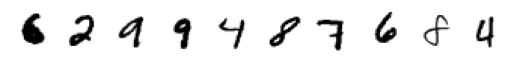

tensor([6, 2, 9, 9, 4, 8, 7, 6, 8, 4])

In [7]:
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.axis('off')
    plt.imshow(X[idx, :, :, :].reshape(28, 28), cmap='gray_r')
plt.show()
y[:10]

### 모델 만들기

In [17]:
# 모델 구조 설계

class MnistCnn(nn.Module):
    def __init__(self):
        super(MnistCnn, self).__init__()
        # Cnn이므로 Conv, Pool 필요. out_channels : 필터 개수, padding 수를 직접 지정해야한다. 1=same
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # pool하면서 이미지 28*28이 14*14가 된다. > 한번 더 돌면 7*7
        self.fc1 = nn.Linear(7*7*16, 32)   # flatten하는 것
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        # conv 층 작업
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 7*7*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [18]:
# 학습 도구 구성
model = MnistCnn().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

MnistCnn(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


In [19]:
# 훈련 함수 정의 (배치 10으로 하니 너무 많아서 300으로 조정)

def train(model, train_loader, optimizer):
    model.train()
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        if idx % 300 == 0:
            print(f'Batch : {idx}, Loss : {loss.item()}')

In [21]:
# 모델 평가 함수 정의

def evaluate(model, test_loader):
    loss_total = 0
    correct_total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels).item()
            loss_total += loss
            predicted_values = output.max(1, keepdim=True)[1]
            correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item() # 비교하기
            correct_total += correct
    
    loss_total /= (len(test_dataset) / 32 )
    accuracy = correct_total / len(test_dataset)
    
    return loss_total, accuracy

In [22]:
# 학습 실행

for epoch in range(10):
    train(model, train_loader, optimizer) 
    loss, accuracy = evaluate(model, test_loader)
    print(f"Epoch : {epoch + 1}, Loss : {loss}, Accuracy : {accuracy}")
    # 에폭마다 validation이 어떻게 개선되는지 볼 수 있게 함. (여기선 validation따로 안 만들어서 test로 함)

Batch : 0, Loss : 0.1050143763422966
Batch : 300, Loss : 0.13350002467632294
Batch : 600, Loss : 0.056602220982313156
Batch : 900, Loss : 0.06836283206939697
Batch : 1200, Loss : 0.10255139321088791
Batch : 1500, Loss : 0.1330542415380478
Batch : 1800, Loss : 0.03466441109776497
Epoch : 1, Loss : 0.07437082510590554, Accuracy : 0.9765
Batch : 0, Loss : 0.07214885950088501
Batch : 300, Loss : 0.1574651151895523
Batch : 600, Loss : 0.038958627730607986
Batch : 900, Loss : 0.04552131146192551
Batch : 1200, Loss : 0.10108233243227005
Batch : 1500, Loss : 0.015540869906544685
Batch : 1800, Loss : 0.17434747517108917
Epoch : 2, Loss : 0.059447656825184825, Accuracy : 0.9809
Batch : 0, Loss : 0.01084250770509243
Batch : 300, Loss : 0.04211652651429176
Batch : 600, Loss : 0.017277929931879044
Batch : 900, Loss : 0.04753003641963005
Batch : 1200, Loss : 0.04209510609507561
Batch : 1500, Loss : 0.02186363935470581
Batch : 1800, Loss : 0.16521048545837402
Epoch : 3, Loss : 0.05043749718591571, Ac

In [23]:
# 최종적인 작업

evaluate(model, test_loader)
# 

(0.05625466647148132, 0.9839)